<a href="https://colab.research.google.com/github/alexandrebatista/cifar10-classifier/blob/master/cifar_wnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/alexandrebatista/cifar10-classifier.git

fatal: destination path 'cifar10-classifier' already exists and is not an empty directory.


In [2]:
!pip install wisardpkg

In [3]:
!python /content/cifar10-classifier/mnist_classifier.py

Acc: 0.9242857142857143


## Pré-Processamento

Pensei em testar alguns métodos de pré-processamento. A idéia é aumentar o banco de treino para tentar aumentar a robustez do modelo:

* shifting: rotacionar, transladar e alterar o zoom das imagens (para nós, pode parecer a mesma imagem, mas para a máquina são imagens diferentes).

* filtros: aplicar alguns filtros para realçar determinadas features.

Referências:

https://towardsdatascience.com/how-to-improve-your-image-classifier-with-googles-autoaugment-77643f0be0c9

https://github.com/DeepVoltaire/AutoAugment

https://towardsdatascience.com/image-filters-in-python-26ee938e57d2


In [4]:
!git clone https://github.com/DeepVoltaire/AutoAugment.git

fatal: destination path 'AutoAugment' already exists and is not an empty directory.


In [5]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pdb
from autoaugment import ImageNetPolicy, CIFAR10Policy, SVHNPolicy, SubPolicy

In [6]:
import PIL
print("Using Pillow version {}. Upgrade using 'pip install Pillow -U'".format(PIL.__version__))

Using Pillow version 7.0.0. Upgrade using 'pip install Pillow -U'


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


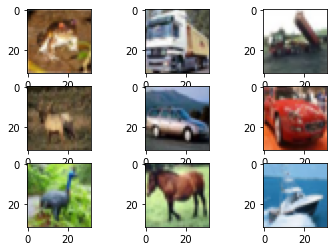

In [7]:
# example of loading the cifar10 dataset
from matplotlib import pyplot
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

In [8]:
def show_sixteen(images, titles=0):
    f, axarr = plt.subplots(4, 4, figsize=(15, 15), gridspec_kw={"wspace": 0, "hspace": 0})
    for idx, ax in enumerate(f.axes):
        ax.imshow(images[idx])
        ax.axis("off")
        if titles: ax.set_title(titles[idx])
    plt.show()

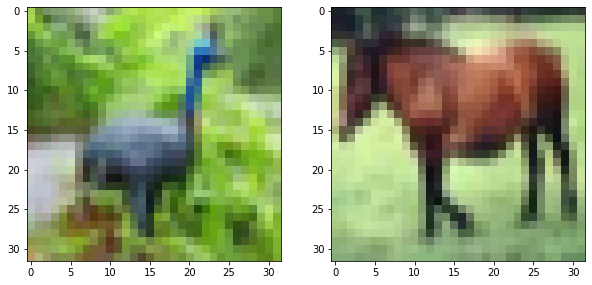

In [9]:
img = trainX[6]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.imshow(img)
img2 = trainX[7]
ax2.imshow(img2)
plt.show()

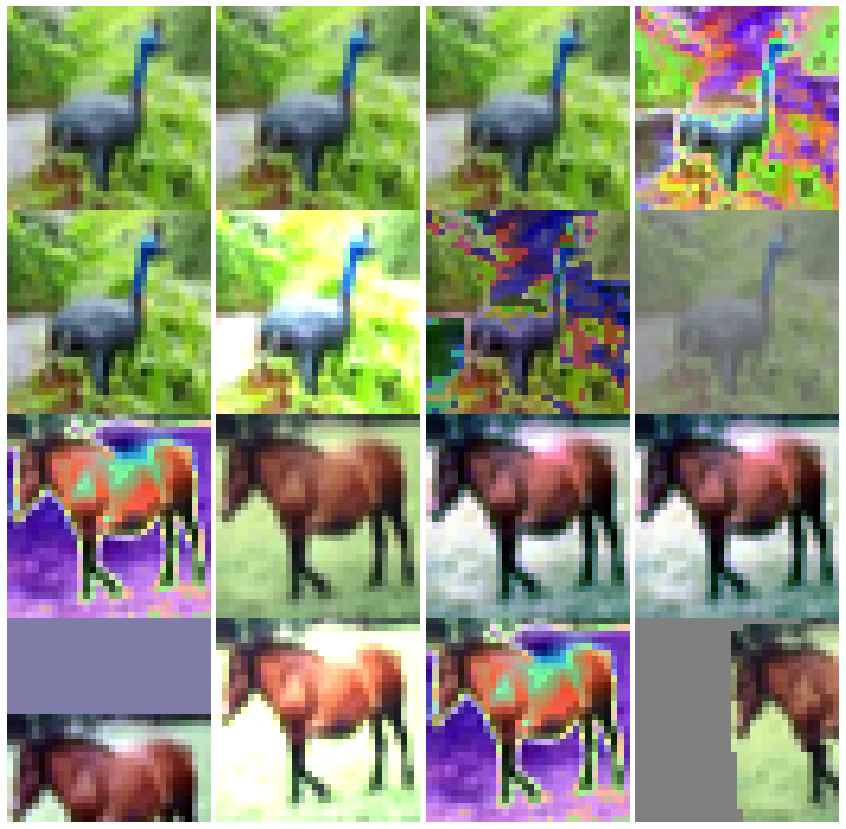

In [10]:
img1a = PIL.Image.fromarray(img)
img2a = PIL.Image.fromarray(img2)

#policy = ImageNetPolicy()
policy = CIFAR10Policy()

imgs = []
for _ in range(8): imgs.append(policy(img1a))
for _ in range(8): imgs.append(policy(img2a))
show_sixteen(imgs)

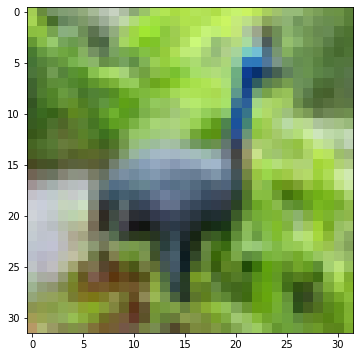

In [11]:
teste = np.asarray(imgs[0]) 
f, ax1 = plt.subplots(1, 1, figsize=(10,6))
ax1.imshow(teste)

In [12]:
%%time
def preproc(trainX, trainy, nsample=8):
  ntrainX = []
  ntrainy = []

  for tX, ty in zip(trainX, trainy):
    tXimg = PIL.Image.fromarray(tX)
    policy = CIFAR10Policy()
    for _ in range(nsample): ntrainX.append(np.asarray(policy(tXimg)))
    for _ in range(nsample): ntrainy.append(ty)

  return np.array(ntrainX), np.array(ntrainy)


#ntrainX, ntrainy = preproc(trainX, trainy, nsample=3)
#print('Train: X=%s, y=%s' % (ntrainX.shape, ntrainy.shape))

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


In [13]:
import wisardpkg as wp
def simple_cifar(train_data, train_labels, test_data, test_labels):

  def flatten(char):
      return np.reshape(char, (-1,)).tolist()

  # ----------------------------------------------------------------------------------------------------------------------
  # Preprocessing data

  # Converting labels from int to string
  train_labels = [str(label) for label in train_labels]
  test_labels = [str(label) for label in test_labels]

  #threshold = 125
  #X = np.where(train_data > threshold, 1, 0)
  #y = np.where(test_data > threshold, 1, 0)
  # trainingSet, validationSet, testSet = np.split(X, [int(len(X) * 0.8), int(len(X) * 0.9)])
  # trainingSetY, validationSetY, testSetY = np.split(y, [int(len(y) * 0.8), int(len(y) * 0.9)])

  # Normalizando os dados
  X = train_data / 255.0
  y = test_data / 255.0

  # Hot-encode:
  X = [flatten(sample) for sample in X]
  y = [flatten(sample) for sample in y]

  # ----------------------------------------------------------------------------------------------------------------------
  # Setting model

  addressSize = 28
  ignoreZero = False

  model = wp.Wisard(addressSize, ignoreZero=ignoreZero, verbose=True)

  # ----------------------------------------------------------------------------------------------------------------------
  # Training
  model.train(X, train_labels)

  # ----------------------------------------------------------------------------------------------------------------------
  # Testing
  out = model.classify(y)

  # ----------------------------------------------------------------------------------------------------------------------
  # Evaluation
  hits = 0
  for index in range(0, len(out)):
      if str(out[index]) == str(test_labels[index]):
          hits = hits + 1

  acc = float(hits) / len(test_labels)
  print('Acc: ' + str(acc))
  return

In [14]:
%%time
# original
#simple_cifar(trainX, trainy, testX, testy)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


In [ ]:
%%time
# original sem thresold, com normalizacao
simple_cifar(trainX, trainy, testX, testy)

In [ ]:
%%time
# x2
simple_cifar(ntrainX, ntrainy, testX, testy)

In [ ]:
%%time
# x3
simple_cifar(ntrainX, ntrainy, testX, testy)